In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm

In [3]:
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output

In [4]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/4/train.csv')

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


<1> Clustering

  1) Remove rides to/from far away areas

In [6]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]

df = df[(df.pickup_longitude > xlim[0])&(df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

  2) Plot locations

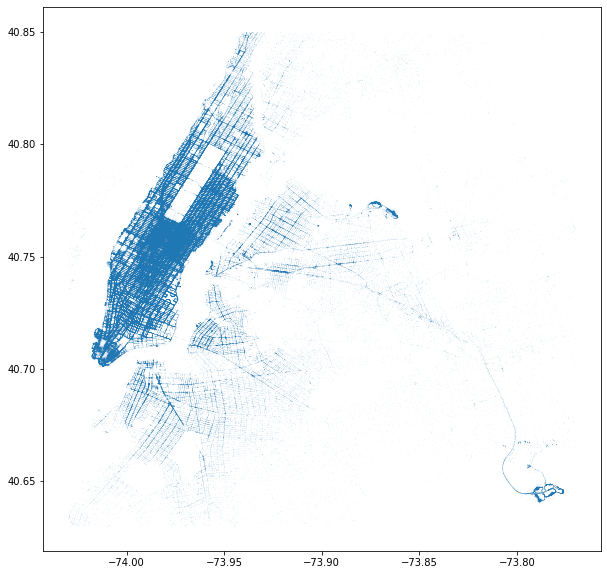

In [7]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

택시 탑승, 하차 지점의 (longitude, latitude)를 plot하니 지도 비스무리한 그림이 나왔다</br>
location을 loc 이라는 dataframe에 담아보자!

In [8]:
loc = pd.DataFrame()
loc['longitude'] = longitude
loc['latitude'] = latitude

  3) Cluster New York City based in pick-up and drop-off points

In [9]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

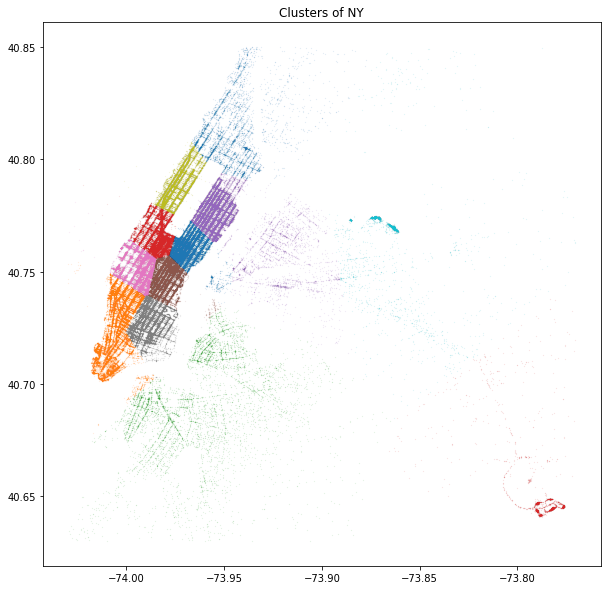

In [10]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc)
loc['label'] = kmeans.labels_

loc = loc.sample(200000)
plt.figure(figsize=(10,10))
for label in loc.label.unique():
  plt.plot(loc.longitude[loc.label == label], loc.latitude[loc.label == label], '.', alpha=0.3, markersize=0.3)

plt.title('Clusters of NY')
plt.show()

As we can see, the clustering results in a partition which is somewhat similar to the way NY is divided into different neighborhoods. We can see Upper East and West side of Central park in gray and pink respectively. West midtown in blue, Chelsea and West Village in brown, downtown area in blue, East Village and SoHo in purple.

The airports JFK and La LaGuardia have there own cluster, and so do Queens and Harlem. Brooklyn is divided into 2 clusters, and the Bronx has too few rides to be separated from Harlem.

  4) Plot the cluster centers

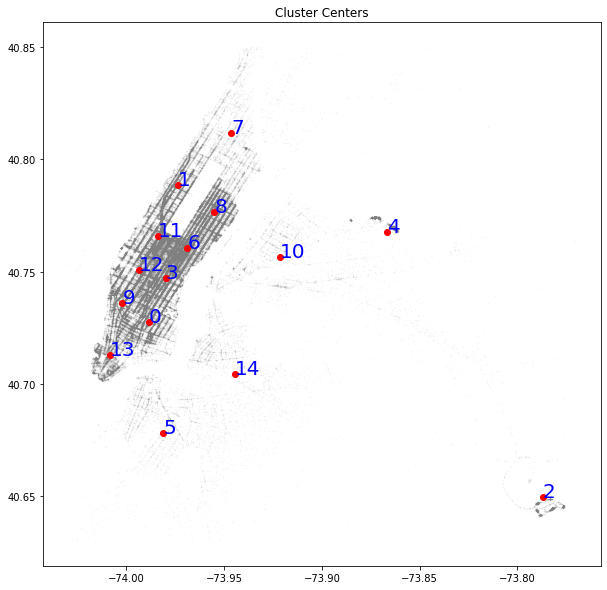

In [11]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc.label.unique():
    ax.plot(loc.longitude[loc.label == label],loc.latitude[loc.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [12]:
kmeans.cluster_centers_

array([[-73.98846204,  40.72745476],
       [-73.97381545,  40.7883167 ],
       [-73.78718399,  40.6494662 ],
       [-73.97980307,  40.74718301],
       [-73.8666204 ,  40.76740598],
       [-73.98106299,  40.67830747],
       [-73.96893692,  40.76045533],
       [-73.94629558,  40.81169885],
       [-73.95501392,  40.77633692],
       [-74.00199601,  40.73600375],
       [-73.92139937,  40.75665856],
       [-73.98401278,  40.76569673],
       [-73.99357934,  40.75089159],
       [-74.00824659,  40.71290811],
       [-73.94447511,  40.70436961]])

In [13]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [14]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

<2> Plot rides from one cluster to another

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

Manually assign neighbor name to each cluster

In [15]:
neighborhood = {-74.0019368351: 'Chelsea',
                -73.837549761: 'Queens',
                -73.7854240738: 'JFK',
                -73.9810421975:'Midtown-North-West',
                -73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',
                -73.9866739677: 'Brooklyn-parkslope',
                -73.8690098118: 'LaGuardia',
                -73.9890572967:'Midtown',
                -74.0081765545: 'Downtown',
                -73.9213024854: 'Queens-Astoria',
                -73.9470256923: 'Harlem',
                -73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',
                -73.9745967889:'Upper West Side'}

In [16]:
rides = pd.DataFrame(columns=neighborhood.values())
rides['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [17]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

for col in rides.columns[:-1]:
    rides[col] = rides.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [18]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour,pickup_neighborhood,dropoff_neighborhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,11,6,17,Midtown-North-West,Midtown-North-East
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,3,9,0,Midtown-North-West,Chelsea
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,13,11,Midtown-North-West,Downtown
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,13,13,19,Downtown,Downtown
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1,1,13,Upper West Side,Midtown-North-East


In [19]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides.values),
                  x = rides.columns[:-1],
                  y = rides.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(size = 30,color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
    yaxis = dict(title = ' <b> From </b>'),
    xaxis = dict(title = '<b> To </b>'))

data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

We can see that center Manhattan neighborhoods are the most taxi-crowded, with Upper East side as the leader. We also see that the most common ride is within the cluster (which can not be seen in the animation).

The heatmap is fairly symmetrical, meaning that there aren't clusters that significantly have more pickups than dropoffs or the other way around.

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

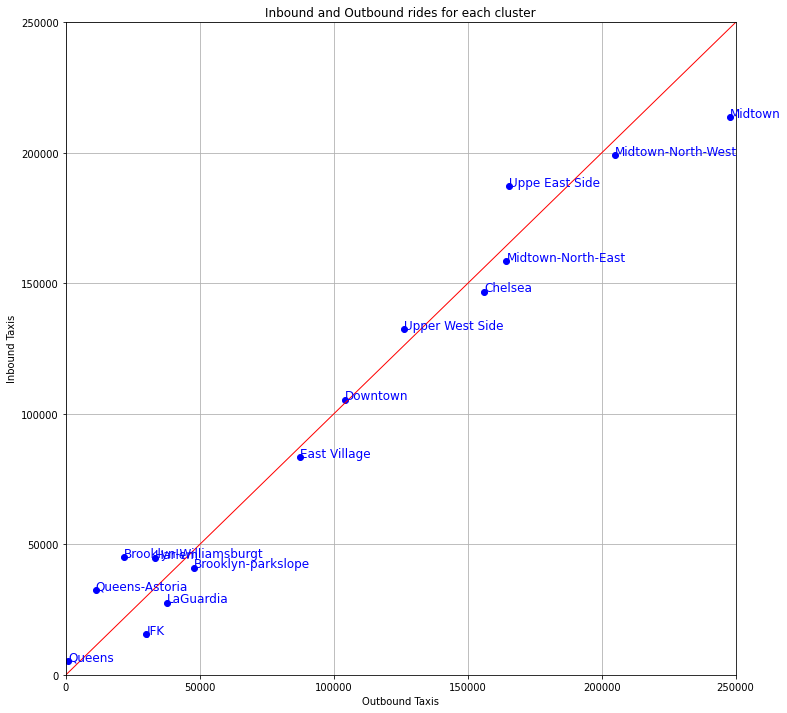

In [20]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides)):  
    ax.plot(rides.sum(axis = 1)[i],rides.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides.name.tolist()[i], (rides.sum(axis = 1)[i], rides.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

-> </br>
  -Inbound-Outbound ratio is relatively balanced.</br>
  -공항 (JFK, LaGuardia) : more outbounds</br>
  -commercial, touristic areas : more outbound</br>
  -주거지역 (Queens, Brooklyn, Harlem) : more inbound

<3> Seasonal Rides

In [21]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x : parser.parse(x).month)

In [26]:
rides.columns[:-1]

Index(['Chelsea', 'Queens', 'JFK', 'Midtown-North-West', 'East Village',
       'Midtown-North-East', 'Brooklyn-parkslope', 'LaGuardia', 'Midtown',
       'Downtown', 'Queens-Astoria', 'Harlem', 'Uppe East Side',
       'Brooklyn-Williamsburgt', 'Upper West Side'],
      dtype='object')

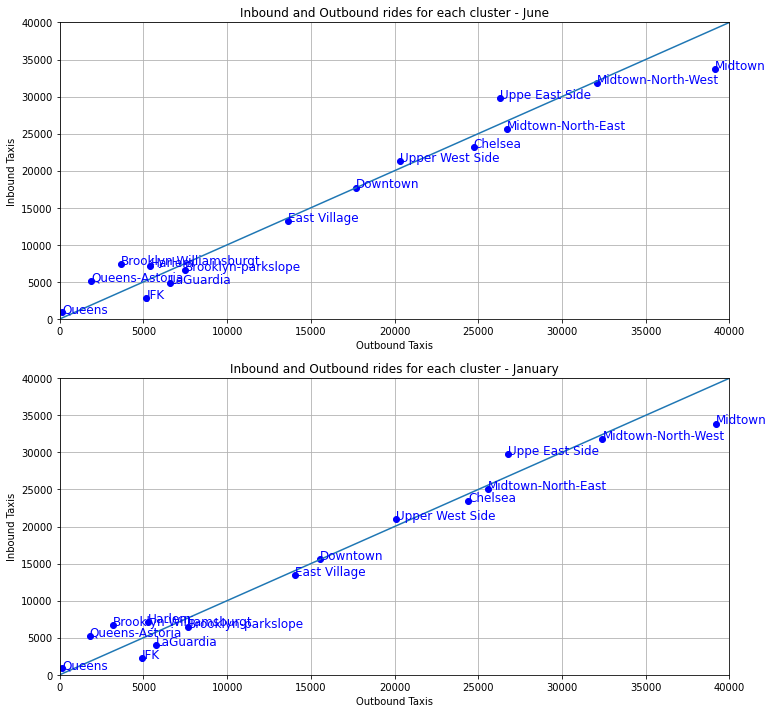

In [27]:
fig, ax = plt.subplots(2, figsize=(12,12))

rides = pd.DataFrame(columns=neighborhood.values())
rides['name'] = neighborhood.values()
rides.index = rides.name

for col in rides.columns[:-1]:
  rides[col] = rides['name'].apply(lambda x : len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides)):  
  ax[0].plot(rides.sum(axis = 1)[i],rides.sum(axis = 0)[i],'o', color = 'b')
  ax[0].annotate(rides.name[i], (rides.sum(axis = 1)[i],rides.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])

for col in rides.columns[:-1]:
  rides[col] = rides['name'].apply(lambda x : len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
for i in range(len(rides)):
  ax[1].plot(rides.sum(axis=1)[i], rides.sum(axis=0)[i], 'o', color='b')
  ax[1].annotate(rides.name[i], (rides.sum(axis=1)[i], rides.sum(axis=0)[i]), color='b', fontsize=12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])